In [ ]:
# Import packages
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, , LeakyReLU, BatchNormalization, Activation, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.optimizers import Adam
import zipfile



: 

In [ ]:
# Download the dataset saved on drive using ID
!gdown "put the ID of the file here"

Downloading...
From: https://drive.google.com/uc?id=1Diy9CxcIFX0JMbRqw-NixT2Gl2hMHzzb
To: /content/Dataset.zip
100% 594M/594M [00:10<00:00, 57.5MB/s]


In [ ]:
# Drive dataset path
dataset_path = '/content/drive/My Drive/Dataset.zip'

In [ ]:
def extract_zip(zip_path, extraction_path):
    """
    Extracts the contents of a zip file to a specified extraction directory.

    Parameters:
    - zip_path (str): Path to the zip file to be extracted.
    - extraction_path (str): Path to the directory where the contents will be extracted.

    Returns:
    - None
    """
    # Create the extraction directory if it doesn't exist
    os.makedirs(extraction_path, exist_ok=True)
    
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)


In [ ]:
# Path to the zipped dataset file in Google Drive
dataset_file_path = '/content/Dataset.zip'

# Directory where you want to extract the images
extraction_path = '/content/'


In [ ]:
# Set dataset parameters
target_size= (128,128)
batch_size=64

In [ ]:
# Set train and val directories
train_dir = '/content/Dataset/train'
val_dir = '/content/Dataset/validation'

In [ ]:
def is_image_file(filename):
    """
    Checks if a given filename has a valid image extension (JPEG or PNG).

    Parameters:
    - filename (str): The name of the file to be checked.

    Returns:
    bool: True if the file has a valid image extension, False otherwise.
    """

    return filename.lower().endswith((".jpg", ".png"))


In [ ]:
def load_images(directory, target_size):
    """
    Loads images from a specified directory, resizes them to a target size, and returns a NumPy array.

    Parameters:
    - directory (str): Path to the directory containing the images.
    - target_size (tuple): A tuple specifying the target size (height, width) to resize the images.

    Returns:
    numpy.ndarray: A NumPy array containing the loaded and resized images.

    """

    images = [np.array(Image.open(os.path.join(directory, filename)).resize(target_size))
              for filename in os.listdir(directory) if is_image_file(filename)]

    # Rescale the images to the range [0, 1]
    images = np.array(images) / 255.0  # Rescale by dividing by 255.0
    images = tf.cast(images, tf.float32)
    return images


In [ ]:
# Load train and val images
train_images = load_images(train_dir, target_size)
val_images = load_images(val_dir, target_size)

In [ ]:
def apply_noise_image(image, scale=10):
    """
    Applies Gaussian noise to an input image.

    Parameters:
    - image (numpy.ndarray): Input image.
    - scale (float, optional): Scaling factor for the noise intensity. Defaults to 10.

    Returns:
    - numpy.ndarray: Noised image.
    """

    # Generate Gaussian noise with the same shape as the image
    noise = np.random.randn(*image.shape)

    # Scale the noise to fit the [0, 1] range
    noise = noise * (scale / 255.0)  # Assuming the original image was in the range [0, 255]

    # Add the scaled noise to the image
    noised_image = image + noise

    # Ensure that the resulting image is still within [0, 1]
    noised_image = np.clip(noised_image, 0, 1)
    
    # Convert the image to float32
    noised_image = tf.cast(noised_image, tf.float32)

    return noised_image

In [ ]:
# Apply noise to train and val images
noised_train_images = np.array([apply_noise_image(image) for image in train_images])
noised_val_images = np.array([apply_noise_image(image) for image in val_images])

In [ ]:
def show_images(images, nmax=4):
    """
    Visualizes a list of images.

    Parameters:
    - images (list): List of images to be visualized.
    - nmax (int, optional): Maximum number of images to display. Defaults to 4.

    Returns:
    - None
    """
    
    # Create subplots based on the number of images to display
    fig, ax = plt.subplots(ncols=min(len(images), nmax), figsize=(12, 4))

    # Iterate through the images and display them
    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.axis('off')

    # Show the plot
    plt.show()


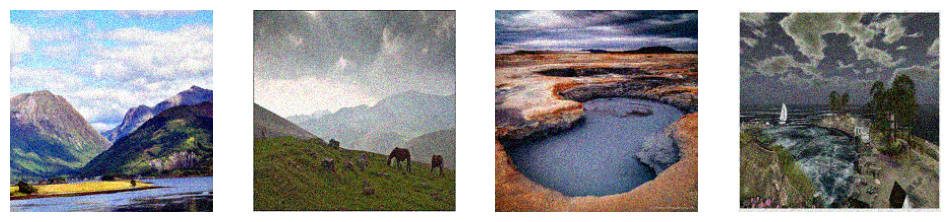

In [ ]:
# Visualize noised images
show_images(noised_train_images)

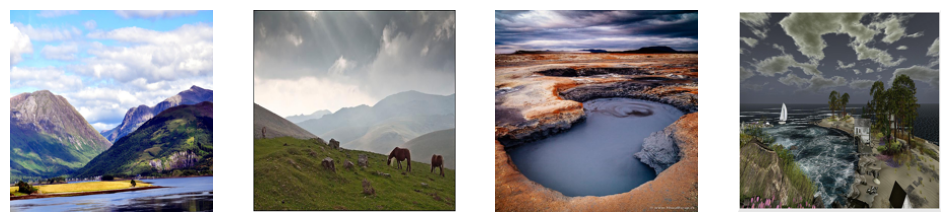

In [ ]:
# Visualize train images
show_images(train_images)

In [ ]:
# Define img shape for training
image_shape = target_size + (3,)

In [ ]:

def build_autoencoder(image_shape):
    """
    Builds a Convolutional AutoEncoder model.

    Parameters:
    - image_shape (tuple): Shape of the input images (height, width, channels).

    Returns:
    - tf.keras.models.Model: Convolutional AutoEncoder model.
    """
    # Weights initialization
    initializer = GlorotNormal()

    # Encoder
    inputs = Input(shape=image_shape)
    x = Conv2D(64, (3, 3), kernel_initializer=initializer, padding='same')(inputs)
    x = LeakyReLU(alpha=0.02)(x)  # Leaky ReLU activation
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)  # Leaky ReLU activation
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)  # Leaky ReLU activation
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = LeakyReLU(alpha=0.02)(x)  # Leaky ReLU activation
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)  # Leaky ReLU activation
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)  # Leaky ReLU activation
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='linear', padding='same')(x)

    # AutoEncoder Model
    autoencoder = tf.keras.models.Model(inputs, decoded)

    return autoencoder


In [ ]:
import tensorflow as tf

def ssim_metric(original, reconstructed):
    """
    Compute Structural Similarity Index (SSIM) between two images.

    SSIM is a metric that measures the similarity between two images, taking into account luminance, contrast,
    and structure. It returns a value between -1 and 1, where 1 indicates identical images.

    Parameters:
    - original (tf.Tensor): The original image.
    - reconstructed (tf.Tensor): The reconstructed image.

    Returns:
    - float: SSIM value between the original and reconstructed images.
    """
    ssim = tf.image.ssim(original, reconstructed, max_val=1.0)
    return ssim

def psnr_metric(img1, img2):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) between two images.

    PSNR is a metric that measures the quality of the reconstructed image compared to the original image.
    It is expressed in decibels (dB), and higher values indicate better image quality.

    Parameters:
    - img1 (tf.Tensor): The original image.
    - img2 (tf.Tensor): The reconstructed image.

    Returns:
    - float: PSNR value between the original and reconstructed images.
    """
    psnr = tf.image.psnr(img1, img2, max_val=1.0)
    return psnr


In [ ]:
# Build the model
autoencoder= build_autoencoder(image_shape)
# Compile the model
# Select the optimizer, loss function and metrics for the model
learning_rate=0.0001

optimizer = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[ssim_metric, psnr_metric])

# Print model summary
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_29 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                           

In [ ]:
# Set training parameters
batch_size=32
n_epochs=1000

In [ ]:
# Train AUtoEncoder
history = autoencoder.fit(noised_train_images, train_images, batch_size=batch_size, epochs=n_epochs,validation_data=(noised_val_images, val_images) )


Epoch 1/1000
86/86 [==============================] - 10s 90ms/step - loss: 0.0633 - ssim_metric: 0.3732 - psnr_metric: 13.8808 - val_loss: 0.0173 - val_ssim_metric: 0.4638 - val_psnr_metric: 18.0345
Epoch 2/1000
86/86 [==============================] - 7s 78ms/step - loss: 0.0127 - ssim_metric: 0.4827 - psnr_metric: 19.6679 - val_loss: 0.0091 - val_ssim_metric: 0.5163 - val_psnr_metric: 21.0221
Epoch 3/1000
86/86 [==============================] - 7s 79ms/step - loss: 0.0085 - ssim_metric: 0.5236 - psnr_metric: 21.5927 - val_loss: 0.0073 - val_ssim_metric: 0.5475 - val_psnr_metric: 22.0839
Epoch 4/1000
86/86 [==============================] - 7s 78ms/step - loss: 0.0073 - ssim_metric: 0.5476 - psnr_metric: 22.3144 - val_loss: 0.0066 - val_ssim_metric: 0.5660 - val_psnr_metric: 22.5896
Epoch 5/1000
86/86 [==============================] - 7s 80ms/step - loss: 0.0067 - ssim_metric: 0.5634 - psnr_metric: 22.7370 - val_loss: 0.0063 - val_ssim_metric: 0.5778 - val_psnr_metric: 22.7073
Epoc

In [ ]:
# Get reconstructed validation images from AutoEncoder
reconstructed_images = autoencoder.predict(val_images)

In [ ]:
def score_autoencoder(val_images, reconstructed_images):
    """
    Calculates SSIM and PSNR scores between validation images and reconstructed images.

    Parameters:
    - val_images (numpy.ndarray): Validation images.
    - reconstructed_images (numpy.ndarray): Reconstructed images.

    Returns:
    - float: Average SSIM (Structural Similarity Index).
    - float: Average PSNR (Peak Signal-to-Noise Ratio).
    """
    ssim_scores = []
    psnr_scores = []

    # Compute SSIM and PSNR between val images and reconstructed validation images
    for i in range(len(val_images)):
        ssim_score = ssim_metric(val_images[i], reconstructed_images[i])
        psnr_score = psnr_metric(val_images[i], reconstructed_images[i])
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    # Calculate average SSIM and PSNR
    average_ssim = np.mean(ssim_scores)
    average_psnr = np.mean(psnr_scores)

    return average_ssim, average_psnr, ssim_scores, psnr_scores


In [ ]:
# Compute SSIM and PSNR scores between validation images and reconstructed images from validation images
average_ssim, average_psnr, ssim_scores, psnr_scores = score_autoencoder(val_images, reconstructed_images)
print("Average SSIM:", average_ssim)
print("Average PSNR:", average_psnr)


37/37 [==============================] - 1s 23ms/step
Average SSIM: 0.82120454
Average PSNR: 28.622751


In [ ]:
import matplotlib.pyplot as plt

def show_autoencoder_output(noised_val_images, reconstructed_images, val_images, save_path="Comparisons.png"):
    """
    Visualizes the outputs of image processing.

    Parameters:
    - noised_val_images (numpy.ndarray): Noised validation images.
    - reconstructed_images (numpy.ndarray): Reconstructed images.
    - val_images (numpy.ndarray): Original validation images.
    - save_path (str, optional): Path to save the visualization. Defaults to "Comparisons.png".

    Returns:
    - None
    """
    n = len(noised_val_images)
    
    # Increase the figure size
    plt.figure(figsize=(40, 40))

    for i in range(n):
        # Display noisy images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noised_val_images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display denoised images by convolutional autoencoder
        ax = plt.subplot(3, n, i + 1 + n)  # Adjust the index for the second row
        plt.imshow(reconstructed_images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display original images for comparison purposes
        ax = plt.subplot(3, n, i + 1 + 2*n)  # Adjust the index for the third row
        plt.imshow(val_images[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Reduce spacing between images
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    # Save the visualization
    plt.savefig(save_path)

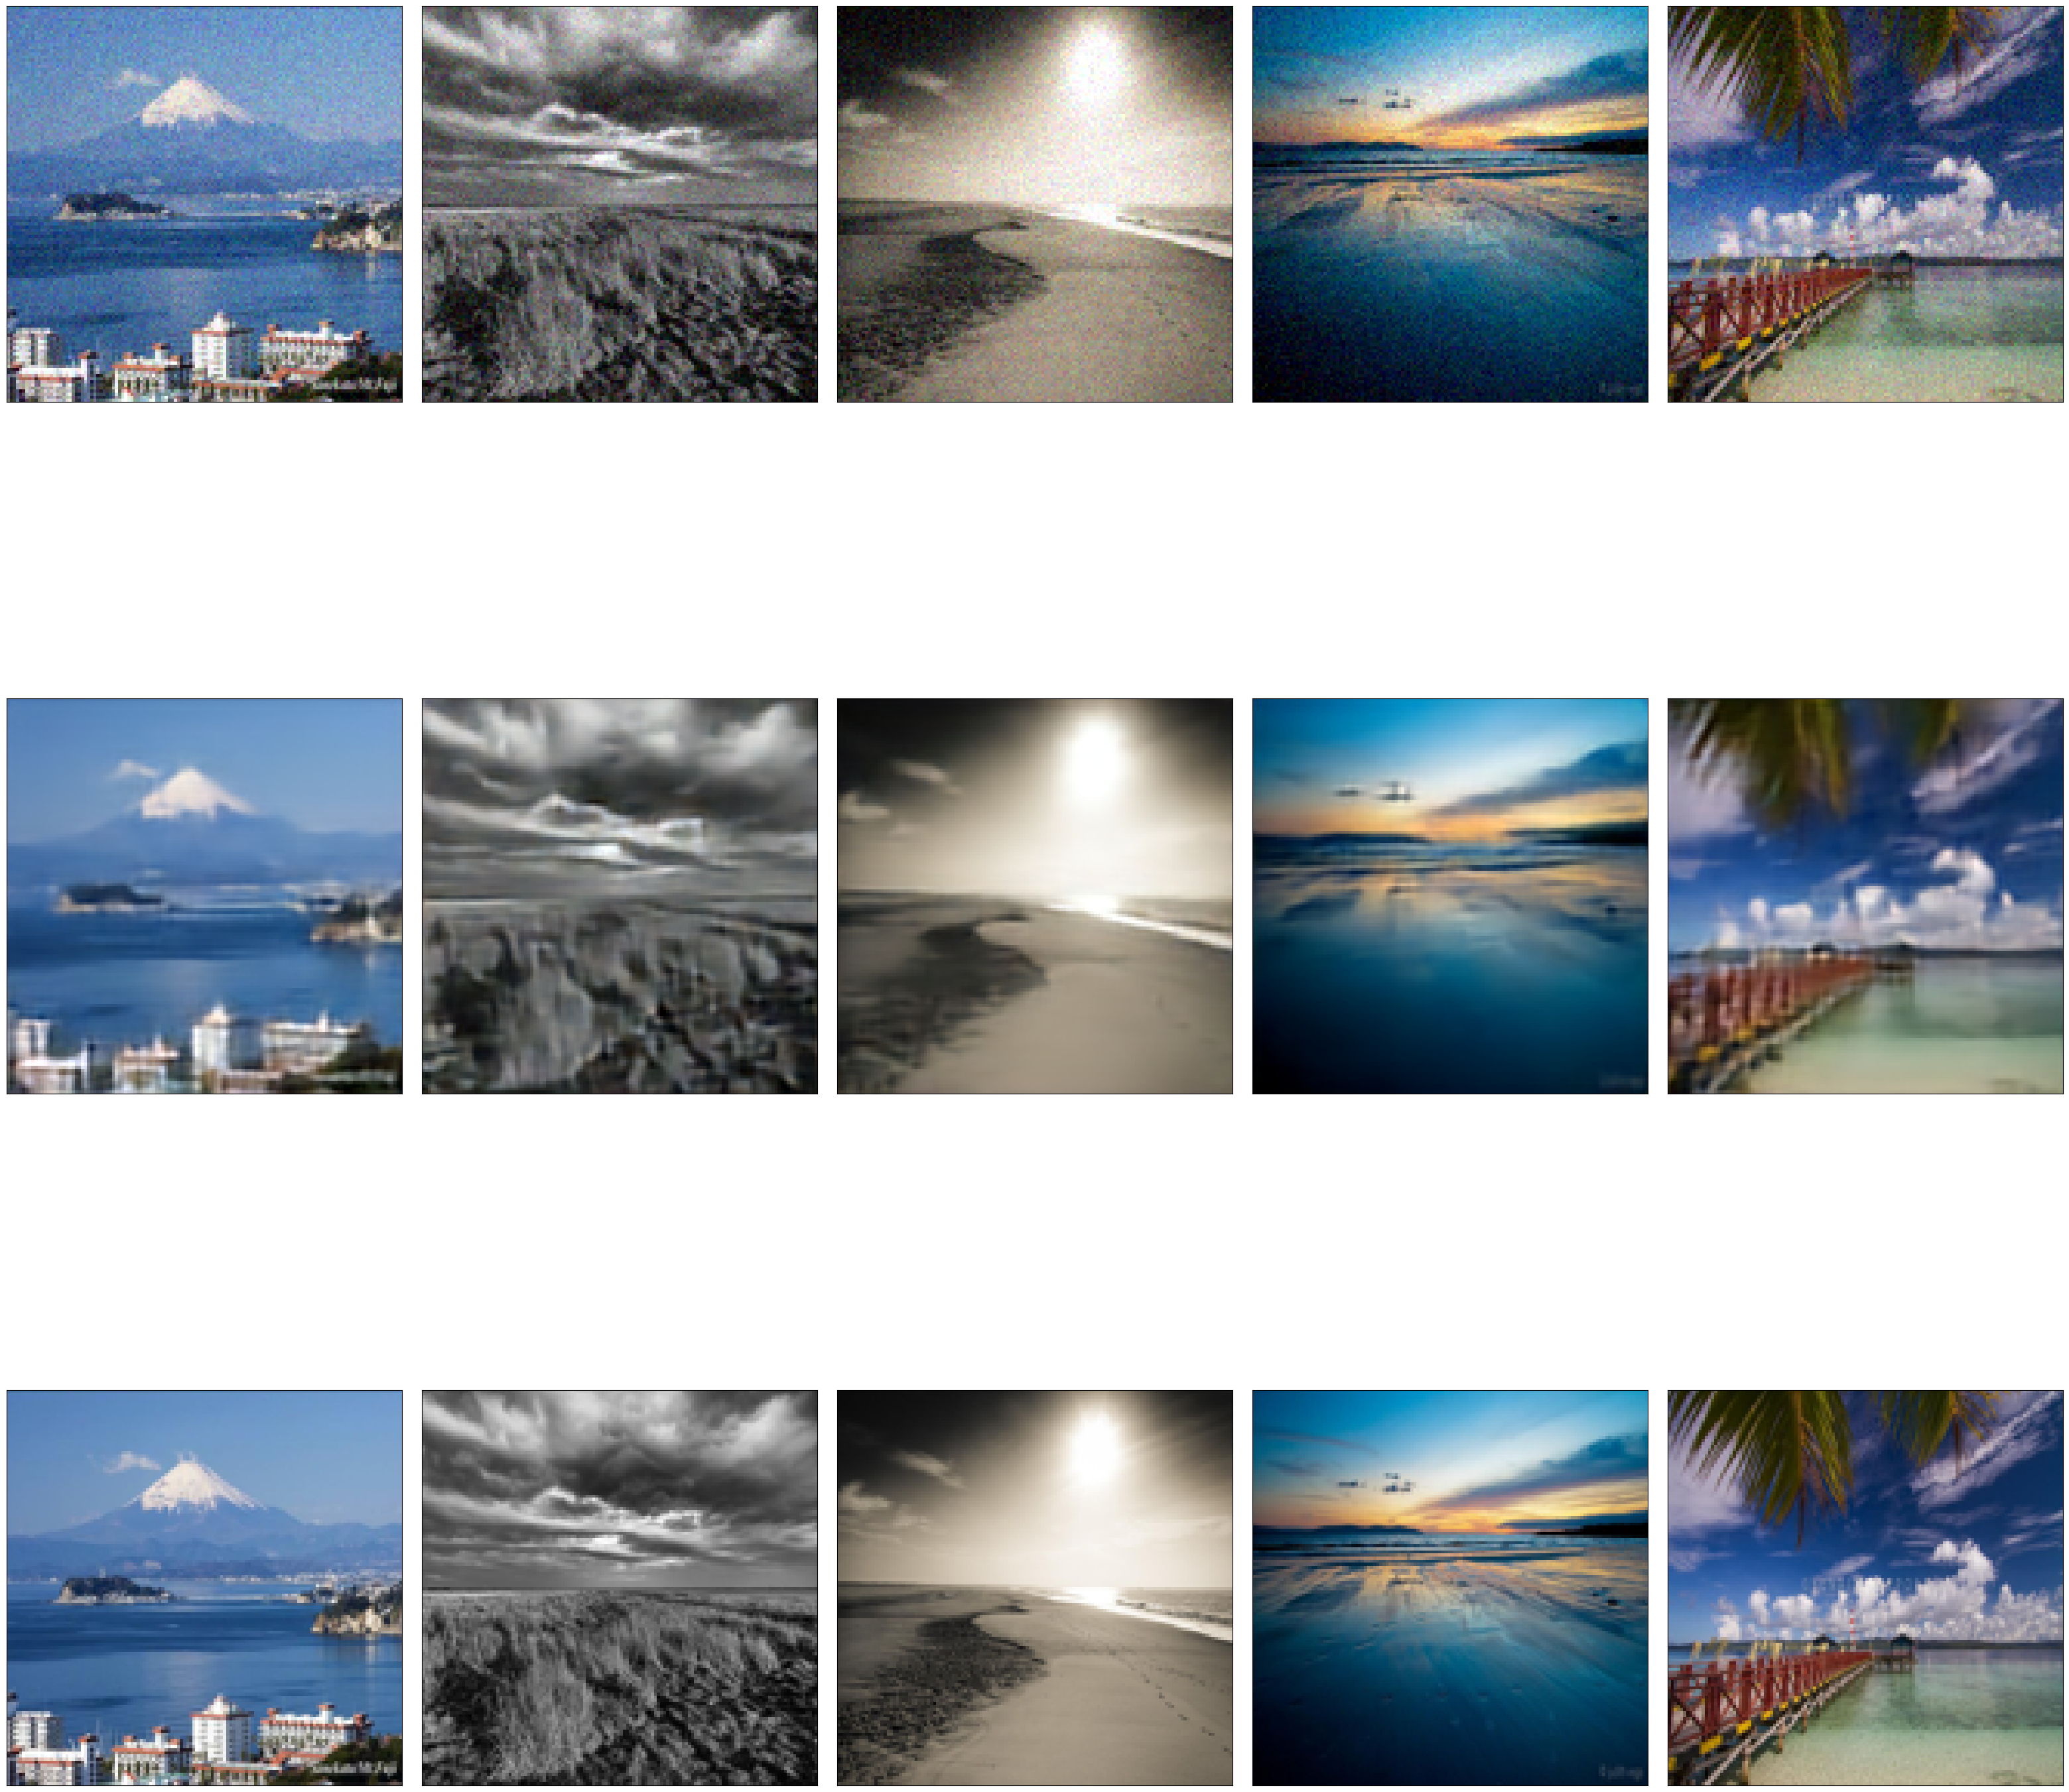

In [ ]:
# Visualize the outputs of the autoencoder
show_autoencoder_output(noised_val_images, reconstructed_images, val_images, save_path="Comparisons.png")

In [ ]:

def plot_loss_curves(history):
    """
    Plots the training and validation loss curves.

    Parameters:
    - history (tf.keras.callbacks.History): Training history of the model.

    Returns:
    - None
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()


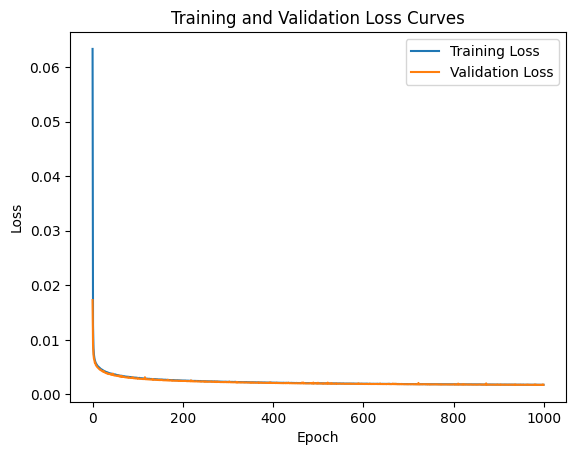

In [ ]:
# Plot the training and validation loss curves
plot_loss_curves(history)

In [ ]:

def plot_loss_and_metrics(history):
    """
    Plots training and validation loss curves, SSIM curve, and PSNR curve.

    Parameters:
    - history (tf.keras.callbacks.History): Training history of the model.

    Returns:
    - None
    """
    # Create subplots for loss and metrics
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Plot the training and validation loss curves
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss Curves')
    axes[0].legend()

    # Plot the SSIM
    axes[1].plot(history.history['ssim_metric'], label='SSIM')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('SSIM')
    axes[1].set_title('SSIM Curve')
    axes[1].legend()

    # Plot the PSNR
    axes[2].plot(history.history['psnr_metric'], label='PSNR')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('PSNR')
    axes[2].set_title('PSNR Curve')
    axes[2].legend()

    plt.tight_layout()
    plt.show()



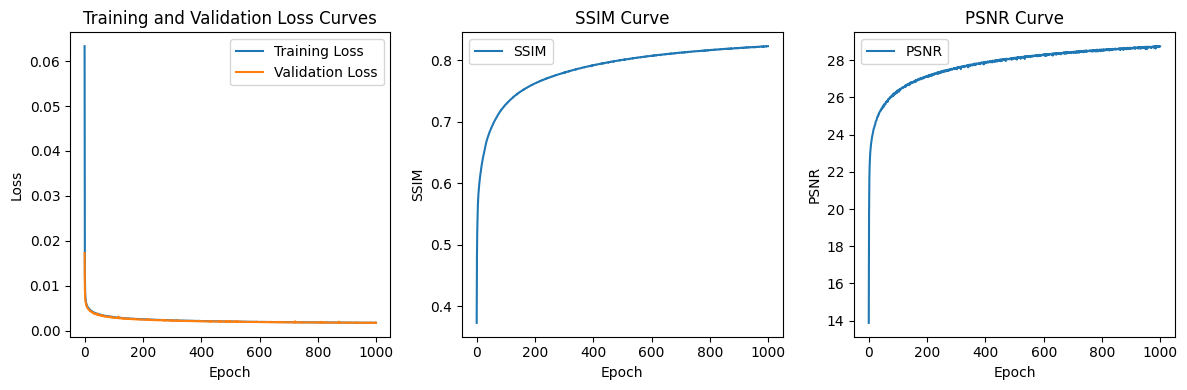

In [ ]:
# Plot the training and validation loss curves, SSIM curve, and PSNR curve
plot_loss_and_metrics(history)

In [ ]:

def plot_ssim_and_psnr(ssim_scores, psnr_scores):
    """
    Creates a graph to visualize SSIM and PSNR values over epochs.

    Parameters:
    - epochs (range): Range of epochs.
    - ssim_scores (list): List of SSIM scores.
    - psnr_scores (list): List of PSNR scores.

    Returns:
    - None
    """
    epochs = range(len(ssim_scores))
    plt.figure(figsize=(10, 6))

    # Plot SSIM values
    plt.plot(epochs, ssim_scores, label='SSIM', marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()

    # Plot PSNR values
    plt.twinx()
    plt.plot(epochs, psnr_scores, label='PSNR', marker='x', linestyle='--', color='tab:orange')
    plt.ylabel('PSNR')
    plt.legend(loc='upper right')

    plt.title('SSIM and PSNR Comparison')
    plt.show()


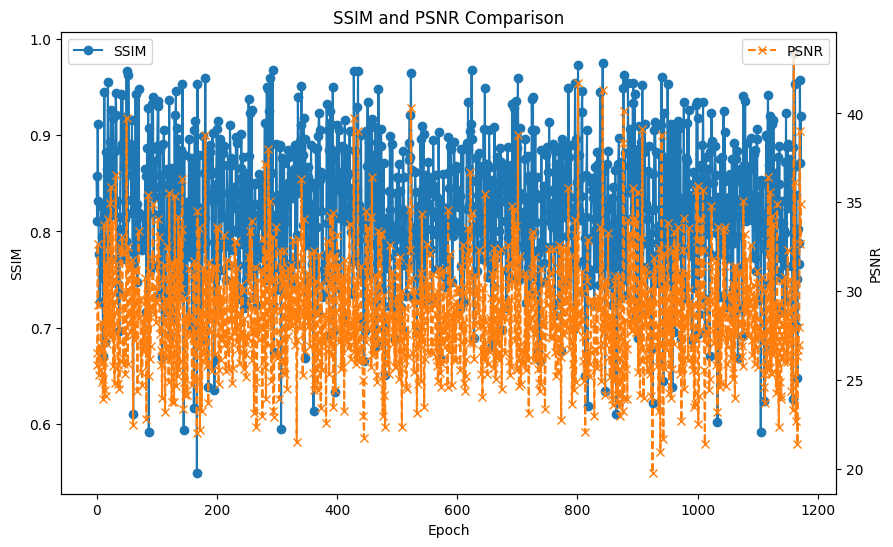

In [ ]:
# Plot SSIM and PSNR values over epochs
plot_ssim_and_psnr(ssim_scores, psnr_scores)

In [ ]:
autoencoder.save('denoising_autoencoder.keras')
# Save trained model
autoencoder.save('denoising_autoencoder.h5')
